In [1]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [5]:

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [6]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [7]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

# load dipersio data

In [21]:

dataset = pd.read_csv(here() / config.data_external / 'xiang_donors.csv').set_index('Patient ID').rename(columns={'Day 1 CD34 Absolute per uL': 'Count',
                                                                   'Day 1 CD34/kg (x10^6)':'optional_outcome'})

# Take the optional outcome into consideration
dataset.loc[(dataset['Count'].isna()) & (dataset['optional_outcome'] >= 2.0), 'Count'] = 100
dataset.loc[(dataset['Count'].isna()) & (dataset['optional_outcome'] < 2.0), 'Count'] = 10

dataset=dataset.drop(['optional_outcome'],axis=1)

In [22]:
dataset

,Count,BMI,Age,Gender F0M1,Sodium,Plasma Potassium,Chloride,Total CO2,Anion Gap,BUN,...,Eos Abs,Baso Abs,Neut Pct,Lymph Pct,Mono Pct,Eos Pct,Baso Pct,PT,INR,aPTT
Patient ID,,,,,,,,,,,,,,,,,,,,,
1,100.0,46.17,39,1,139,4.2,101,29,9,10,...,0.2,0.1,64.5,25.5,7.4,1.9,0.7,11.5,1.00,35.2
2,71.0,23.40,57,0,140,3.9,103,30,7,11,...,0.3,0.1,48.1,41.1,5.9,4.0,0.9,11.5,1.07,35.8
3,87.0,27.97,43,1,141,4.6,105,30,6,12,...,0.1,0.0,58.0,28.7,10.0,2.7,0.6,11.0,1.03,36.2
4,27.0,25.39,50,0,141,3.8,107,28,6,15,...,0.3,0.1,56.4,29.8,7.7,4.8,1.3,12.1,1.13,27.1
5,31.0,17.80,32,0,139,4.2,103,31,5,16,...,0.2,0.0,65.1,26.5,6.4,1.7,0.3,11.8,1.10,35.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,66.8,28.55,42,1,137,4.1,103,24,10,15,...,0.1,0.0,57.0,34.0,7.0,2.0,0.0,12.4,0.96,28.1
796,68.2,29.74,53,1,140,4.8,108,28,4,26,...,0.2,0.0,64.0,30.0,4.0,2.0,0.0,13.1,1.03,25.4
797,55.3,31.46,41,1,136,3.5,102,23,11,13,...,0.1,0.0,55.0,39.0,4.0,1.0,0.0,13.1,1.03,25.5


In [9]:
# remove all rows containing N/A and map samples to respective classes
dataset = dataset.dropna(axis=0, how='any')

dataset.loc[dataset['Count'] < 40, 'Count'] = 0 # bad mobilizers
# dataset.loc[(dataset['Count'] >= 20) & (dataset['Count'] < 40), 'Count'] = 1
# dataset.loc[dataset['Count'] >= 40, 'Count'] = 2
dataset.loc[dataset['Count'] >= 40, 'Count'] = 1 # good mobilizers

In [10]:
# apply linear normalization
df_temp = dataset.iloc[:,1:]
dataset.iloc[:,1:] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [11]:
# oversample the bad mobilizers to balance the dataset with SMOTE
X = dataset.iloc[:,1:]
y = dataset.iloc[:,0]
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)

In [12]:
# convert y in to binary classes
y = (y > 0).astype(int)

In [13]:
print(X.shape, y.shape)

(1256, 42) (1256,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42, stratify=y)

In [15]:
clf = tbp()
clf.fit(X_train, y_train)

TabPFNClassifier()

In [16]:
prediction_prob = clf.predict_proba(X_test)
print('ROC AUC:', roc_auc_score(y_test, prediction_prob[:,1]))

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob[:,1])
roc_auc = auc(fpr, tpr)

ROC AUC: 0.9555303602922651


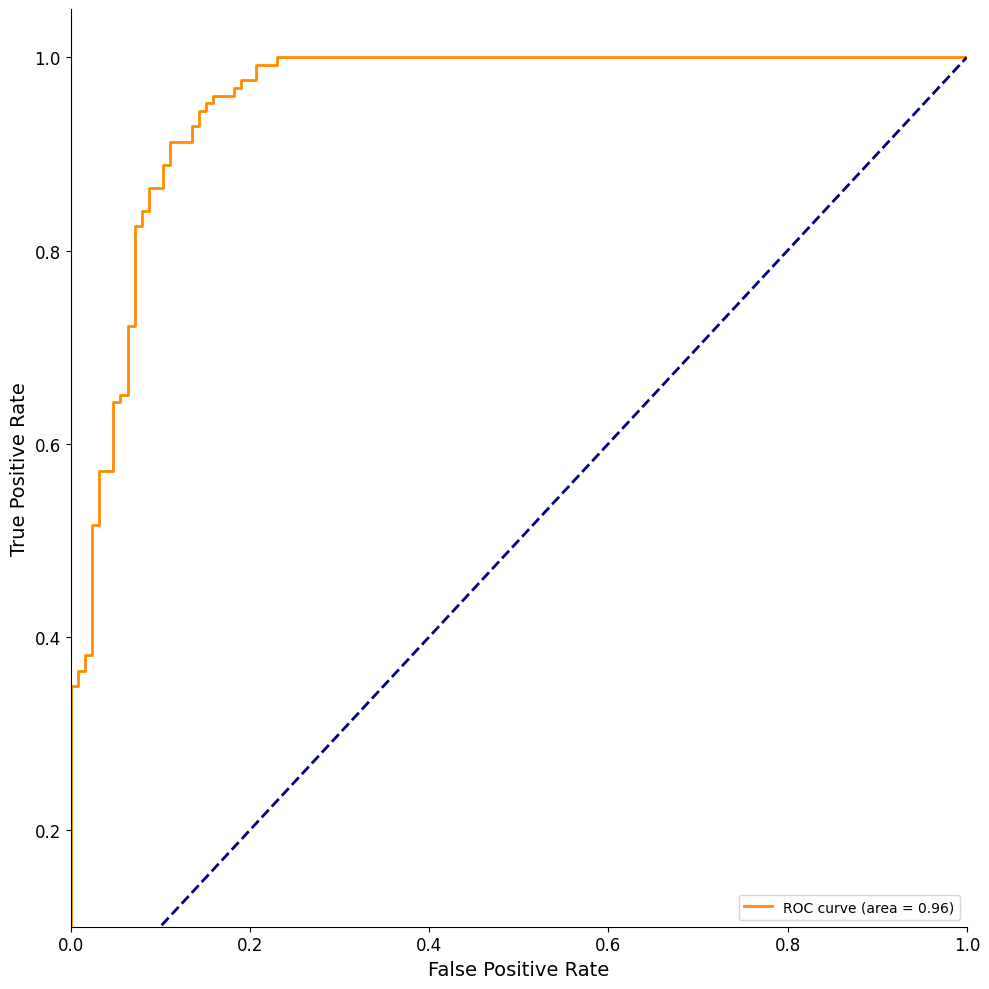

In [17]:

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.fill_between(fpr, tpr, color='lightblue', alpha=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.1, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('ROC Curve')
# plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right")
plt.tight_layout()
sns.despine()
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dipersio' / 'roc_curve.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dipersio' / 'roc_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# plot confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

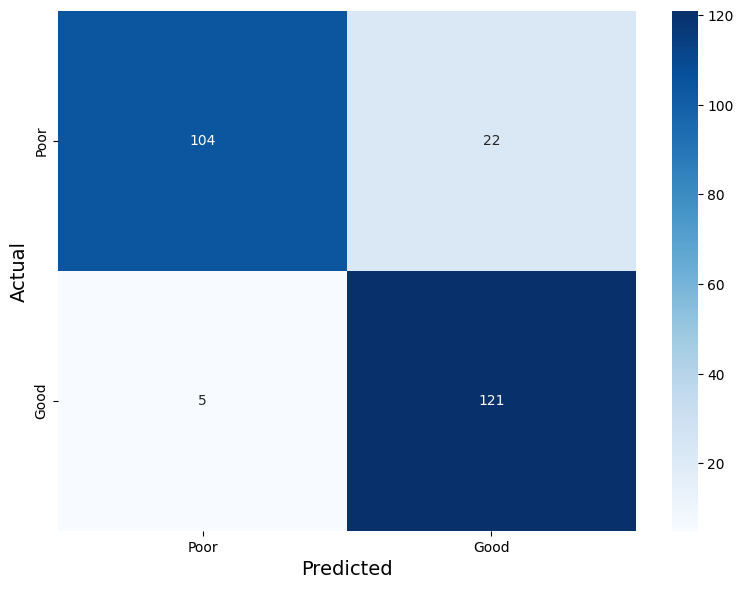

In [19]:

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Good'], yticklabels=['Poor', 'Good'], cbar=True)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)

plt.tight_layout()
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dipersio' / 'confusion_matrix.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dipersio' / 'confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, prediction_prob[:,1])
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {auc:.2f}')

Precision: 0.85
Recall: 0.96
Accuracy: 0.89
F1 Score: 0.90
ROC AUC: 0.96


In [50]:
# print the prediction probabilities of the first 10 samples
print("Prediction probabilities of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {prediction_prob[i]}")
# print the actual labels of the first 10 samples
print("Actual labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_test[i]}")
# print the predicted labels of the first 10 samples
print("Predicted labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_pred[i]}")


Prediction probabilities of the first 10 samples:
Sample 1: [0.10928517 0.8907148 ]
Sample 2: [0.25007555 0.7499244 ]
Sample 3: [0.20276143 0.7972386 ]
Sample 4: [0.298826 0.701174]
Sample 5: [0.12159371 0.8784063 ]
Sample 6: [0.299078 0.700922]
Sample 7: [0.05096383 0.9490362 ]
Sample 8: [0.23634505 0.76365495]
Sample 9: [0.56729615 0.43270382]
Sample 10: [0.41831556 0.58168447]
Sample 11: [0.42701808 0.57298195]
Sample 12: [0.14098199 0.859018  ]
Sample 13: [0.10040556 0.8995944 ]
Sample 14: [0.4490971 0.5509029]
Sample 15: [0.3093336  0.69066644]
Sample 16: [0.39026085 0.6097392 ]
Sample 17: [0.14227176 0.85772824]
Sample 18: [0.08950794 0.91049206]
Sample 19: [0.33656445 0.6634355 ]
Sample 20: [0.03880738 0.9611926 ]
Actual labels of the first 10 samples:
Sample 1: 1
Sample 2: 1
Sample 3: 1
Sample 4: 1
Sample 5: 1
Sample 6: 1
Sample 7: 1
Sample 8: 0
Sample 9: 0
Sample 10: 1
Sample 11: 0
Sample 12: 1
Sample 13: 1
Sample 14: 0
Sample 15: 0
Sample 16: 1
Sample 17: 0
Sample 18: 1
Sampl

# explain the model

In [38]:
from sklearn.datasets import fetch_openml, load_breast_cancer
from tabpfn_extensions import interpretability
from tabpfn import TabPFNClassifier
import shap
# Access SHAP via interpretability.shap, not direct import



In [22]:
feature_names = X.columns.tolist()

In [23]:

n_samples = 200

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    # select random samples for SHAP calculation
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",  # or "auto" for automatic selection
)


PermutationExplainer explainer: 201it [18:38:19, 335.50s/it]                           


In [26]:
# save shap values to a file
out = here() / config.data_interim / 'shap_values_dipersio_all_tabpfn.npz'
np.savez(
    out,
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=shap_values.data
)
print("saved to", out)

saved to c:\workspace_dl\data\interim\shap_values_dipersio_all_tabpfn.npz


In [ ]:

# shap.summary_plot(shap_values_restored, X_test)

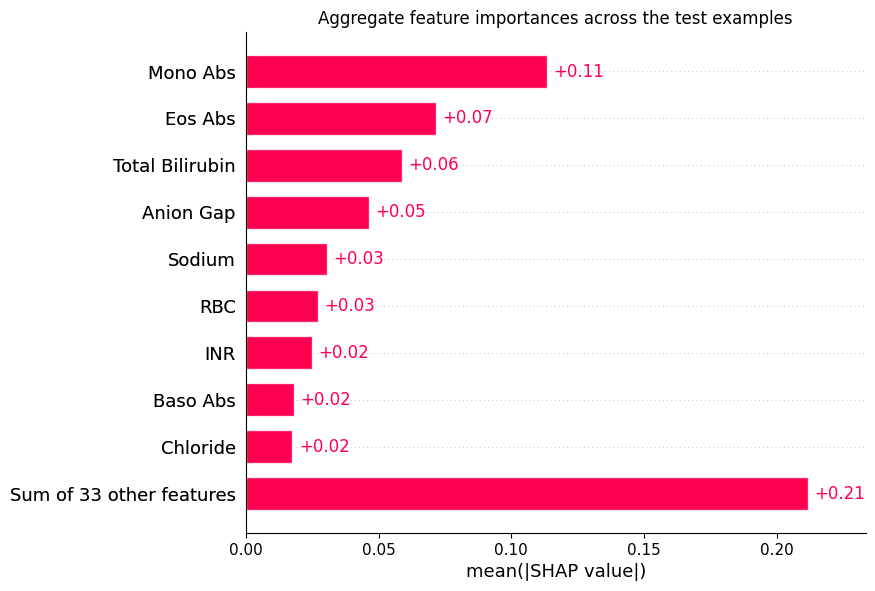

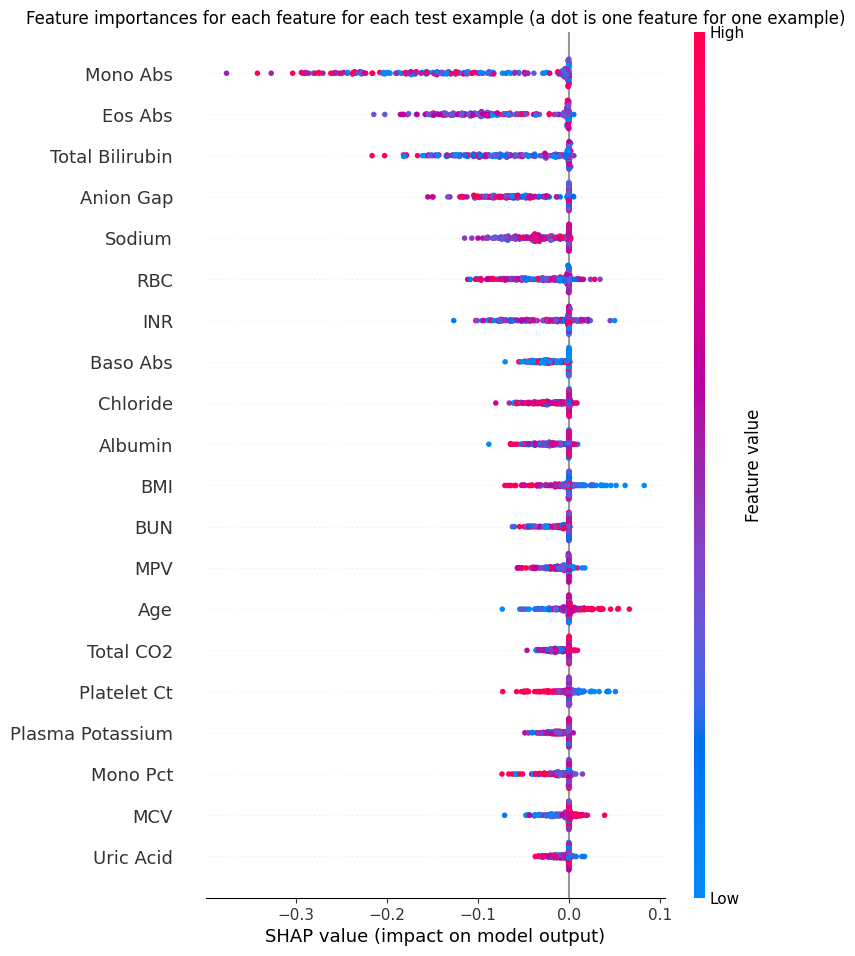

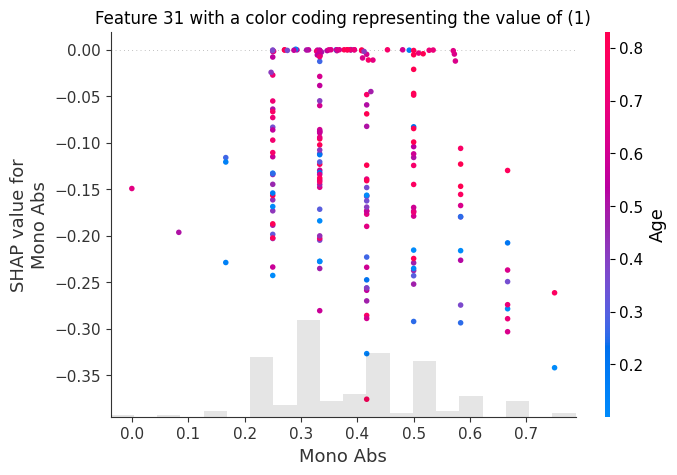

In [25]:
interpretability.shap.plot_shap(shap_values)

PermutationExplainer explainer: 4it [08:42, 174.22s/it]                      


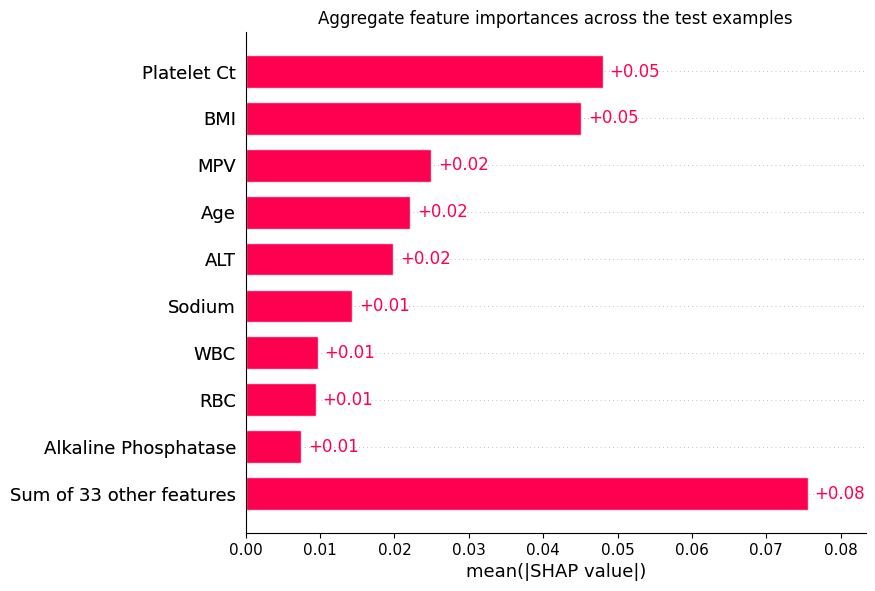

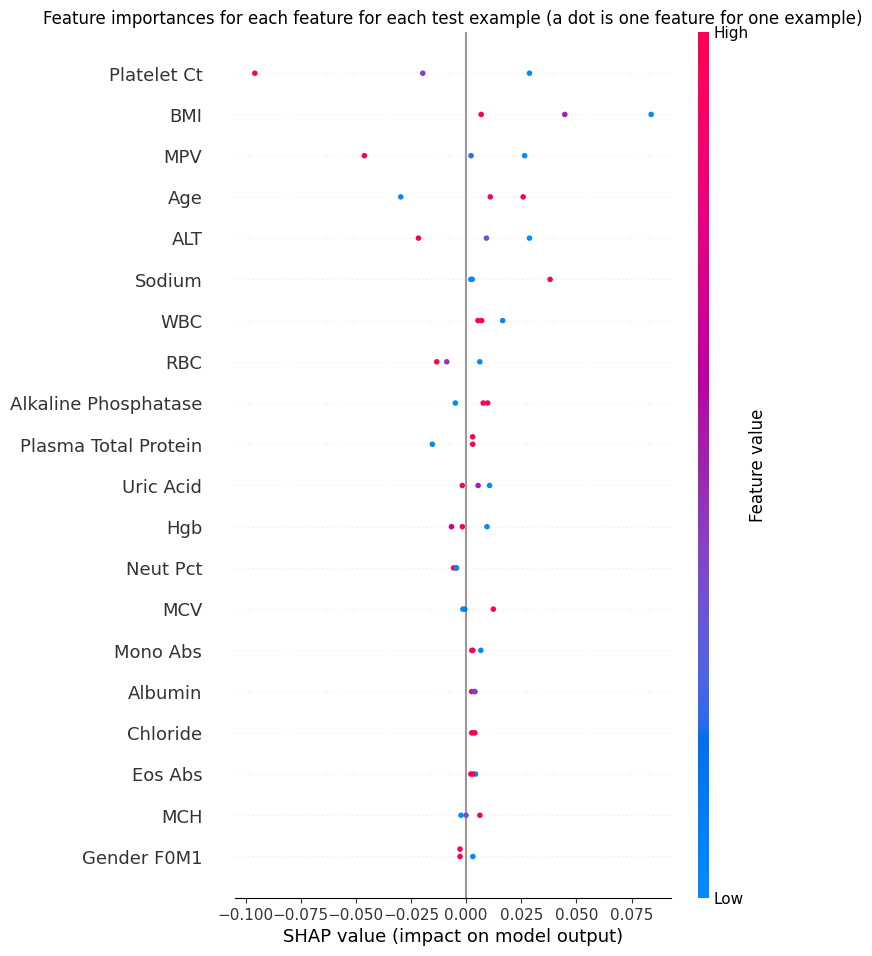

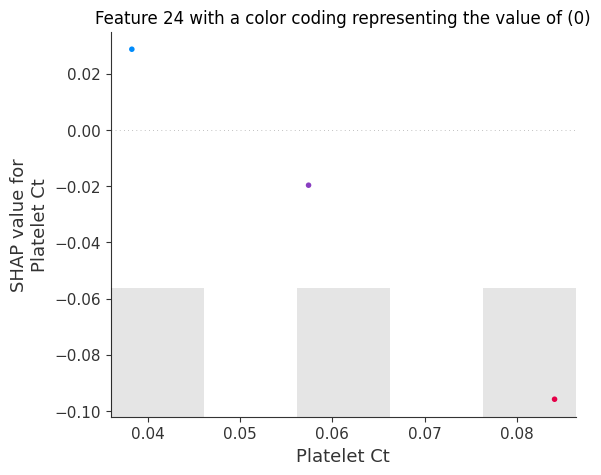

In [ ]:

n_samples = 3

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    # select random samples for SHAP calculation
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization
fig = interpretability.shap.plot_shap(shap_values)

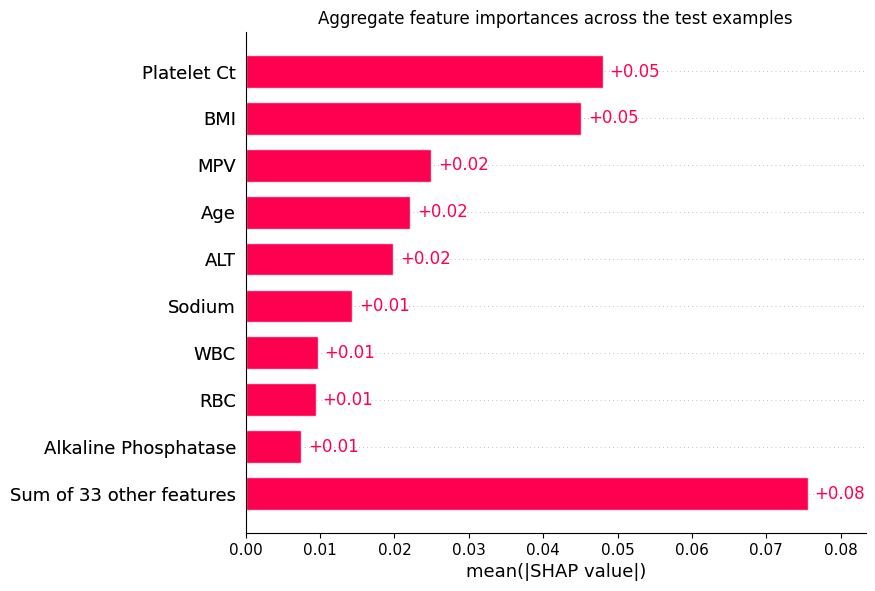

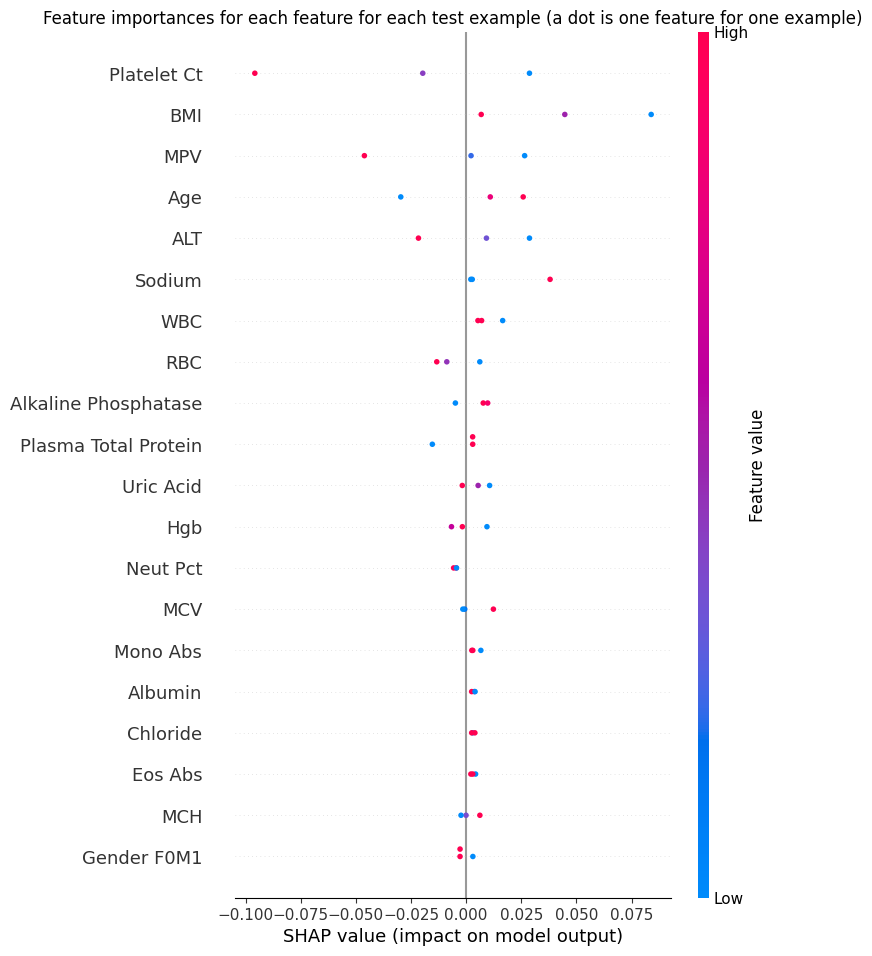

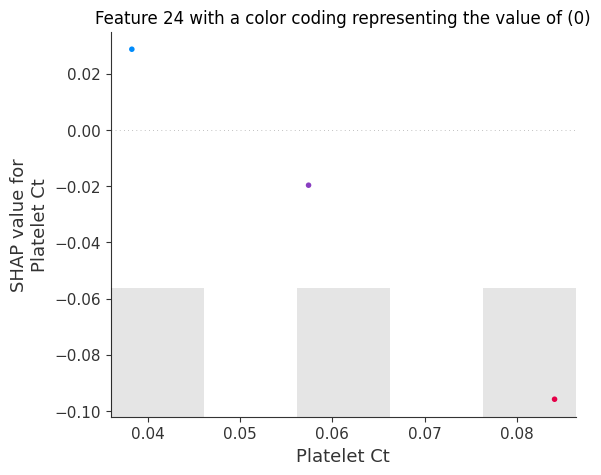

In [ ]:
interpretability.shap.plot_shap(shap_values)


In [48]:
n_samples = 3

In [49]:
n_samples = min(n_samples, X_test.shape[0])

# pick random row‐indices rather than slicing off the top n_samples
idx = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
test_x = X_test[idx]

# now call the permutation‐SHAP routine
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=test_x,
    attribute_names=feature_names,
    algorithm="permutation"
)



PermutationExplainer explainer: 4it [18:15, 365.20s/it]                       


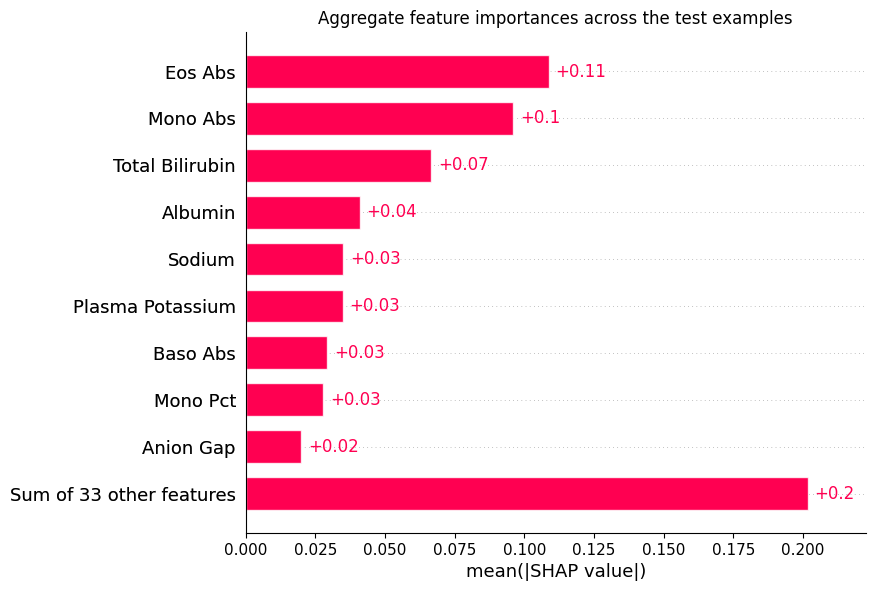

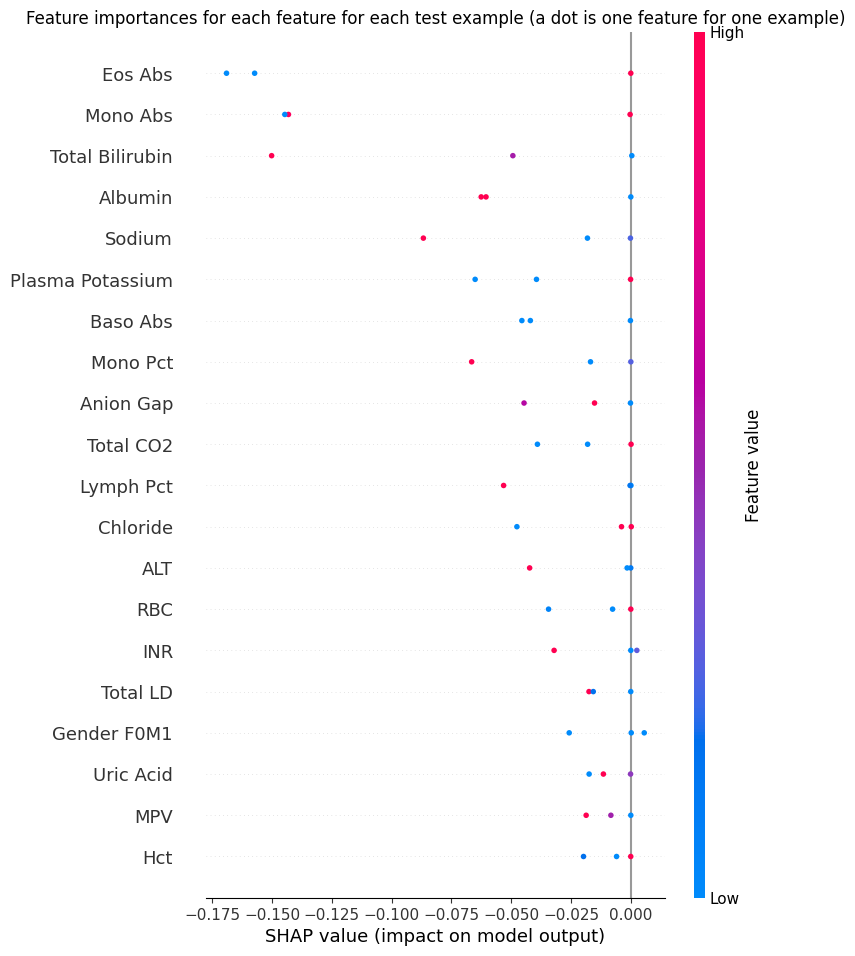

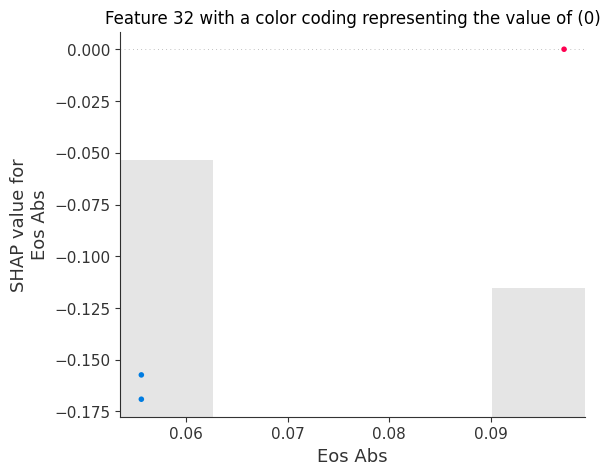

In [50]:
#  plot
fig = interpretability.shap.plot_shap(shap_values)

In [42]:
feature_names = X.columns.tolist()
feature_names

['BMI',
 'Age',
 'Gender F0M1',
 'Sodium',
 'Plasma Potassium',
 'Chloride',
 'Total CO2',
 'Anion Gap',
 'BUN',
 'Creatinine',
 'Total Bilirubin',
 'Uric Acid',
 'Glucose',
 'Total Calcium',
 'Plasma Total Protein',
 'Albumin',
 'Alkaline Phosphatase',
 'ALT',
 'AST',
 'Total LD',
 'WBC',
 'RBC',
 'Hgb',
 'Hct',
 'Platelet Ct',
 'MCV',
 'MCH',
 'MCHC',
 'MPV',
 'Neut Abs',
 'Lymphocyte Abs',
 'Mono Abs',
 'Eos Abs',
 'Baso Abs',
 'Neut Pct',
 'Lymph Pct',
 'Mono Pct',
 'Eos Pct',
 'Baso Pct',
 'PT',
 'INR',
 'aPTT']

In [65]:
data = np.load(here() / config.data_interim / 'shap_values_dipersio_all_tabpfn.npz')

shap_values_restored = shap.Explanation(
    values     = data['values'],      # (n_samples, n_features)
    base_values= data['base_values'], # (n_samples,) or (n_outputs, )
    data       = data['data'],        # the original X_test array
    feature_names = X.columns.tolist()
)


In [ ]:
# Save the SHAP values - select class 1 (positive class) 
shap_values_df = pd.DataFrame(shap_values_restored.values[:, :, 1], columns=X.columns)

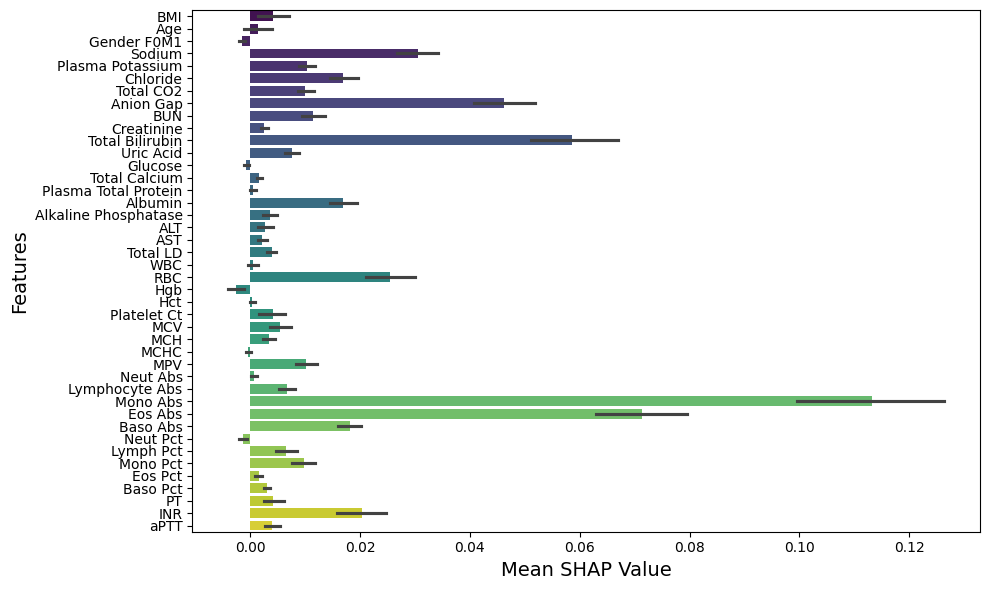

In [56]:
# bar plot the aggregated SHAP values using the shap_values_df
plt.figure(figsize=(10, 6))
sns.barplot(data=shap_values_df, orient='h', palette='viridis')
plt.xlabel('Mean SHAP Value', fontsize=14) 
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

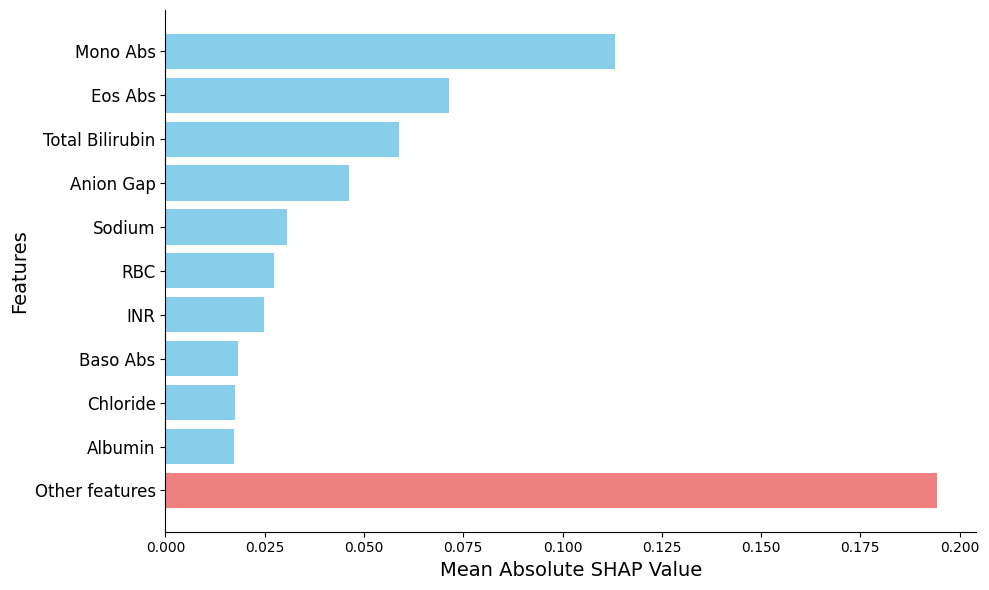

In [61]:
# Calculate mean absolute SHAP values for each feature
mean_shap = shap_values_df.abs().mean().sort_values(ascending=False)

# Get top 10 features
top_10_features = mean_shap.head(10)
other_features_sum = mean_shap.iloc[10:].sum()

# Create a new series with top 10 + "Other features"
plot_data = pd.concat([top_10_features, pd.Series({'Other features': other_features_sum})])

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(plot_data)), plot_data.values, 
                color=['skyblue' if i < 10 else 'lightcoral' for i in range(len(plot_data))])

# Customize the plot
plt.yticks(range(len(plot_data)), plot_data.index, fontsize=12)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
# plt.title('Top 10 Feature Importance + Others', fontsize=16)

# Add value labels on bars
# for i, (bar, value) in enumerate(zip(bars, plot_data.values)):
#     plt.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
            #  f'{value:.3f}', va='center', fontsize=10)

plt.gca().invert_yaxis()  # Top feature at top
plt.tight_layout()
sns.despine()
plt.show()

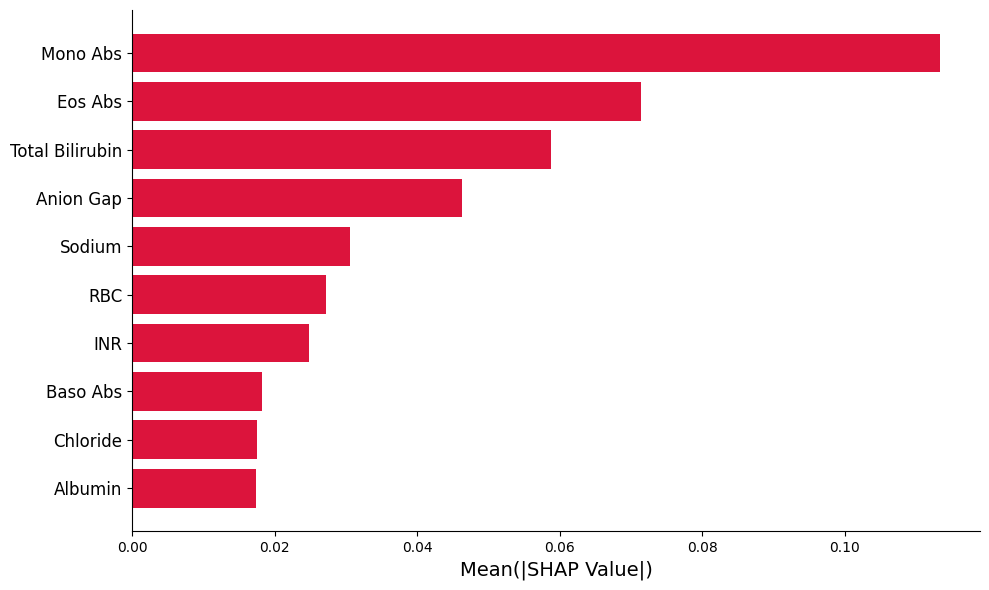

In [69]:
# Calculate mean absolute SHAP values for each feature
mean_shap = shap_values_df.abs().mean().sort_values(ascending=False)

# Get top n features (e.g., top 10)
n = 10
top_n_features = mean_shap.head(n)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(top_n_features)), top_n_features.values, color= 'crimson')

# Customize the plot
plt.yticks(range(len(top_n_features)), top_n_features.index, fontsize=12)
plt.xlabel('Mean(|SHAP Value|)', fontsize=14)
# plt.ylabel('Features', fontsize=14)

# Add value labels on bars (optional)
# for i, (bar, value) in enumerate(zip(bars, top_n_features.values)):
#     plt.text(value + 0.001, bar.get_y() + bar.get_height()/2, 
#              f'{value:.3f}', va='center', fontsize=10)

plt.gca().invert_yaxis()  # Top feature at top
plt.tight_layout()
sns.despine()
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dipersio' / 'top_n_features_shap.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dipersio' / 'top_n_features_shap.pdf', dpi=300, bbox_inches='tight')
plt.show()